In [2]:
# import libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [3]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import lr_scheduler

In [4]:
# import Utils (models, ...)
sys.path.append("../Utils/")
from RunModel_Pytorch import RunModel
from CustomModel_Pytorch import NeuralNet

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
# loading dataset - csv data files
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
submit = pd.read_csv('../dataset/sample_submission.csv')
train_df.sample(3)

,image_names,emergency_or_not
1412,1415.jpg,0
411,1813.jpg,0
1459,1734.jpg,0


In [8]:
train_df['emergency_or_not'].value_counts()

0    965
1    681
Name: emergency_or_not, dtype: int64

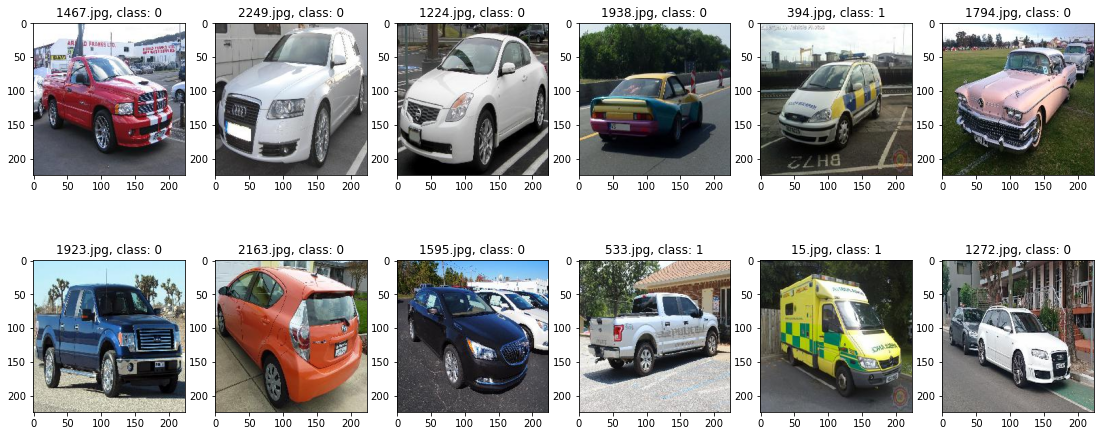

In [9]:
# plot some image examples
path_images='../dataset/images'
plt.figure(figsize = (19, 8))
i=1
for pl in range(12):
    sub=train_df.sample(n=1)
    im=sub['image_names'].values[0]
    label=sub['emergency_or_not'].values[0]
    ax=plt.subplot(2,6,i)
    image=path_images + '/' + im
    img = Image.open(image)
    plt.imshow(img)
    plt.title('{}, class: {}'.format(im,label))
    i+=1

In [10]:
train_df['image_names'].sample(n=1).values[0]

'697.jpg'

In [11]:
X=train_df['image_names'].values
y=train_df['emergency_or_not'].values

In [12]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
X_train, y_train

(array(['720.jpg', '1812.jpg', '1862.jpg', ..., '295.jpg', '1426.jpg',
        '824.jpg'], dtype=object),
 array([1, 0, 0, ..., 1, 0, 1]))

In [14]:
# target_size
target_size = 128
# batch_size
batch_size = 32

In [15]:
# transform compose
train_transform = transforms.Compose([
    transforms.Resize(int(target_size*1.1)),
    transforms.RandomResizedCrop(target_size),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(int(target_size*1.1)),
    transforms.CenterCrop(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224, 0.225])
    ])

In [16]:
# loading images
# Custom Dataset
class VehicleDataset():
    def __init__(self, path_images, features, targets, transform=False):
        self.path_images = path_images
        self.transform = transform
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        image_filepath = self.path_images + '/' + self.features[index]
        image = Image.open(image_filepath)       
        target = self.targets[index]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, target

In [17]:
# create dataset
path_images='../dataset/images'
train_data = VehicleDataset(path_images, X_train, y_train, train_transform)
valid_data = VehicleDataset(path_images, X_val, y_val, test_transform)
#test_data = VehicleDataset(path_images,test_transforms)

In [18]:
len(train_data), len(X_train)

(1316, 1316)

In [19]:
# data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=4, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4, shuffle=False)

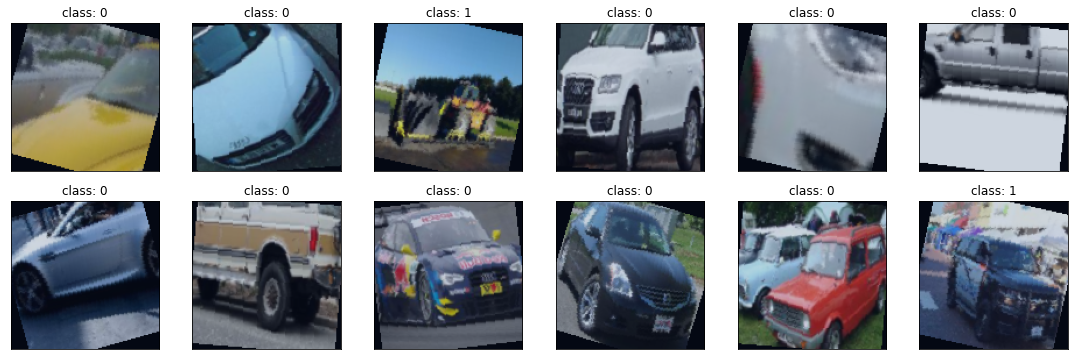

In [20]:
# visualize a batch of the train data loader
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(19, 6))
for i in np.arange(12):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    image_ = np.transpose(images[i], (1, 2, 0)) 
    image_ = image_*[0.18]+[0.4] # unnormalize 
    plt.imshow(image_)
    plt.title('class: {}'.format(labels[i]))

In [21]:
# plot output function
def plot_model_output(history, name='model'):
    
    loss_values = history['train_loss']
    val_loss_values = history['val_loss']
    accuracy_values = history['train_acc']
    val_accuracy_values = history['val_acc']
    
    fig = plt.figure(figsize=(19,3))
    
    plt.subplot(1, 2, 1)
    plt.suptitle(name, fontsize=18)
    plt.title('loss')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,loss_values, '--',label='loss')
    plt.plot(epoch,val_loss_values, '--',label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.suptitle(name, fontsize=18)
    plt.title('accuracy')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,accuracy_values, '--',label='accuracy')
    plt.plot(epoch,val_accuracy_values, '--',label='val_accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

## Pretrained Models

In [55]:
# pretrained models
model_resnet18 = models.resnet18(pretrained=True)
model_resnet34 = models.resnet34(pretrained=True)

In [56]:
for name, param in model_resnet18.named_parameters():
    if("bn" not in name):
        param.requires_grad = False
        
for name, param in model_resnet34.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [57]:
model_resnet18.named_parameters()

<generator object Module.named_parameters at 0x7fa4c0dc86d0>

In [58]:
num_classes = 2

model_resnet18.fc = nn.Sequential(nn.Linear(model_resnet18.fc.in_features,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))

model_resnet34.fc = nn.Sequential(nn.Linear(model_resnet34.fc.in_features,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))

In [59]:
def valid_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))
    return outputs

In [60]:
# pre-trained
valid_model(model_resnet18)

correct: 148  total: 330
accuracy = 0.448485


tensor([[-0.1829,  0.7037],
        [ 0.1193,  0.9142],
        [ 0.5224, -0.2589],
        [ 0.7675,  0.4342],
        [-0.8290,  0.3189],
        [-0.0934,  0.0337],
        [ 0.2752,  0.6264],
        [-0.3484,  1.3171],
        [-0.3801, -0.1088],
        [ 0.4198,  0.1979]])

In [25]:
def valid_model2(model):
    sum_correct = 0
    sum_total = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1], labels).view(-1)
            sum_correct += torch.sum(correct).item()
            sum_total += correct.shape[0]  
    print('correct: {:d}  total: {:d}'.format(sum_correct, sum_total))
    print('accuracy = {:f}'.format(sum_correct / sum_total))
    return F.softmax(outputs, dim=1)

In [62]:
# pre-trained
valid_model2(model_resnet18)

correct: 151  total: 330
accuracy = 0.457576


tensor([[0.1281, 0.8719],
        [0.2603, 0.7397],
        [0.3865, 0.6135],
        [0.2971, 0.7029],
        [0.3954, 0.6046],
        [0.3460, 0.6540],
        [0.4063, 0.5937],
        [0.3628, 0.6372],
        [0.4060, 0.5940],
        [0.2482, 0.7518]])

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=4, threshold=0.000001, threshold_mode='abs', verbose=True)
model_save='../Models/modelo_resnet18.pth'
# RunModel
history = RunModel(model_resnet18, train_loader, valid_loader, criterion, optimizer,
                   scheduler, model_save, n_epochs=30).train_model()

cpu


Epoch: 1, Training_Loss: 0.5662, Validation_Loss: 0.3718, Training_accuracy = 0.7090, Validation_accuracy = 0.8576, lr = 0.001
Validation loss decreased (inf --> 0.371754).  Saving model ...


Epoch: 2, Training_Loss: 0.4080, Validation_Loss: 0.3035, Training_accuracy = 0.8222, Validation_accuracy = 0.8788, lr = 0.001
Validation loss decreased (0.371754 --> 0.303472).  Saving model ...


Epoch: 3, Training_Loss: 0.3960, Validation_Loss: 0.3873, Training_accuracy = 0.8267, Validation_accuracy = 0.8545, lr = 0.001


Epoch: 4, Training_Loss: 0.3721, Validation_Loss: 0.3004, Training_accuracy = 0.8351, Validation_accuracy = 0.8970, lr = 0.001
Validation loss decreased (0.303472 --> 0.300405).  Saving model ...


Epoch: 5, Training_Loss: 0.3762, Validation_Loss: 0.2391, Training_accuracy = 0.8397, Validation_accuracy = 0.9182, lr = 0.001
Validation loss decreased (0.300405 --> 0.239058).  Saving model ...


Epoch: 6, Training_Loss: 0.3489, Validation_Loss: 0.2688, Training_accuracy = 0.8321, Validation_accuracy = 0.8970, lr = 0.001


Epoch: 7, Training_Loss: 0.3092, Validation_Loss: 0.2367, Training_accuracy = 0.8739, Validation_accuracy = 0.9152, lr = 0.001
Validation loss decreased (0.239058 --> 0.236694).  Saving model ...


Epoch: 8, Training_Loss: 0.2895, Validation_Loss: 0.2142, Training_accuracy = 0.8853, Validation_accuracy = 0.9273, lr = 0.001
Validation loss decreased (0.236694 --> 0.214199).  Saving model ...


Epoch: 9, Training_Loss: 0.2917, Validation_Loss: 0.2280, Training_accuracy = 0.8723, Validation_accuracy = 0.9212, lr = 0.001


Epoch: 10, Training_Loss: 0.2611, Validation_Loss: 0.3073, Training_accuracy = 0.8913, Validation_accuracy = 0.8939, lr = 0.001


Epoch: 11, Training_Loss: 0.2759, Validation_Loss: 0.2342, Training_accuracy = 0.8868, Validation_accuracy = 0.9030, lr = 0.001


Epoch: 12, Training_Loss: 0.2617, Validation_Loss: 0.2248, Training_accuracy = 0.8868, Validation_accuracy = 0.9121, lr = 0.001


Epoch: 13, Training_Loss: 0.2741, Validation_Loss: 0.2118, Training_accuracy = 0.8860, Validation_accuracy = 0.9152, lr = 0.001
Validation loss decreased (0.214199 --> 0.211820).  Saving model ...


Epoch: 14, Training_Loss: 0.2517, Validation_Loss: 0.2205, Training_accuracy = 0.8951, Validation_accuracy = 0.9273, lr = 0.001


Epoch: 15, Training_Loss: 0.2439, Validation_Loss: 0.2251, Training_accuracy = 0.8997, Validation_accuracy = 0.9273, lr = 0.001


Epoch: 16, Training_Loss: 0.2542, Validation_Loss: 0.3155, Training_accuracy = 0.8929, Validation_accuracy = 0.8879, lr = 0.001


Epoch: 17, Training_Loss: 0.2820, Validation_Loss: 0.1869, Training_accuracy = 0.8723, Validation_accuracy = 0.9273, lr = 0.001
Validation loss decreased (0.211820 --> 0.186894).  Saving model ...


Epoch: 18, Training_Loss: 0.2550, Validation_Loss: 0.2305, Training_accuracy = 0.8929, Validation_accuracy = 0.9242, lr = 0.001


Epoch: 19, Training_Loss: 0.2380, Validation_Loss: 0.2772, Training_accuracy = 0.8944, Validation_accuracy = 0.9152, lr = 0.001


Epoch: 20, Training_Loss: 0.2398, Validation_Loss: 0.2502, Training_accuracy = 0.9027, Validation_accuracy = 0.9121, lr = 0.001


Epoch: 21, Training_Loss: 0.2217, Validation_Loss: 0.2314, Training_accuracy = 0.9073, Validation_accuracy = 0.9273, lr = 0.001


Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 22, Training_Loss: 0.2708, Validation_Loss: 0.1999, Training_accuracy = 0.8837, Validation_accuracy = 0.9273, lr = 0.0001


Epoch: 23, Training_Loss: 0.2467, Validation_Loss: 0.1931, Training_accuracy = 0.9005, Validation_accuracy = 0.9303, lr = 0.0001


Epoch: 24, Training_Loss: 0.2585, Validation_Loss: 0.2194, Training_accuracy = 0.8906, Validation_accuracy = 0.9182, lr = 0.0001


Epoch: 25, Training_Loss: 0.2394, Validation_Loss: 0.2069, Training_accuracy = 0.9050, Validation_accuracy = 0.9364, lr = 0.0001


Epoch: 26, Training_Loss: 0.2087, Validation_Loss: 0.1840, Training_accuracy = 0.9119, Validation_accuracy = 0.9333, lr = 0.0001
Validation loss decreased (0.186894 --> 0.183955).  Saving model ...


Epoch: 27, Training_Loss: 0.2160, Validation_Loss: 0.2237, Training_accuracy = 0.9134, Validation_accuracy = 0.9242, lr = 0.0001


Epoch: 28, Training_Loss: 0.2301, Validation_Loss: 0.2036, Training_accuracy = 0.9027, Validation_accuracy = 0.9333, lr = 0.0001


Epoch: 29, Training_Loss: 0.2377, Validation_Loss: 0.2022, Training_accuracy = 0.8974, Validation_accuracy = 0.9303, lr = 0.0001


Epoch: 30, Training_Loss: 0.2064, Validation_Loss: 0.2212, Training_accuracy = 0.9103, Validation_accuracy = 0.9242, lr = 0.0001


In [64]:
# post-trained
valid_model(model_resnet18)

correct: 305  total: 330
accuracy = 0.924242


tensor([[-1.6754,  2.7426],
        [-0.2803,  1.4184],
        [-2.1223,  2.6817],
        [-2.7572,  3.1512],
        [-1.8702,  2.9313],
        [ 3.3063, -3.4489],
        [ 3.9870, -3.4328],
        [ 1.4996, -0.9936],
        [-4.1262,  4.7067],
        [ 3.2191, -3.0924]])

In [65]:
# post-trained
valid_model2(model_resnet18)

correct: 305  total: 330
accuracy = 0.924242


tensor([[9.9819e-01, 1.8119e-03],
        [9.7305e-01, 2.6945e-02],
        [3.7656e-01, 6.2344e-01],
        [8.2276e-01, 1.7724e-01],
        [9.9795e-01, 2.0495e-03],
        [2.1036e-03, 9.9790e-01],
        [2.7001e-03, 9.9730e-01],
        [9.0772e-01, 9.2279e-02],
        [2.1439e-01, 7.8561e-01],
        [9.9995e-01, 4.8132e-05]])

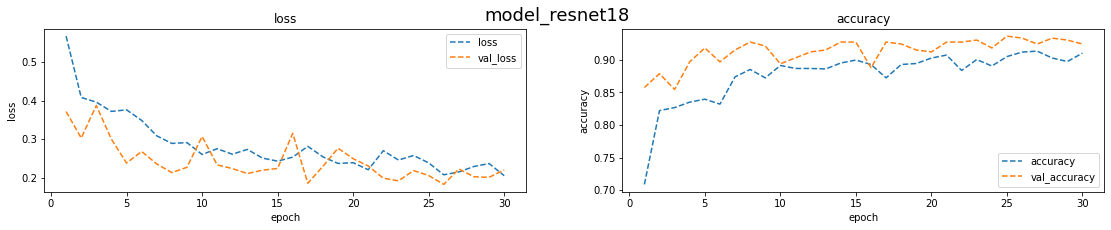

In [66]:
# plot model ouputs
plot_model_output(history, 'model_resnet18')

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet34.parameters(), lr=0.001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=4, threshold=0.000001, threshold_mode='abs', verbose=True)
model_save='../Models/modelo_resnet34.pth'
# RunModel
history = RunModel(model_resnet34, train_loader, valid_loader, criterion, optimizer,
                   scheduler, model_save, n_epochs=30).train_model()

cpu


Epoch: 1, Training_Loss: 0.5339, Validation_Loss: 0.6429, Training_accuracy = 0.7166, Validation_accuracy = 0.7394, lr = 0.001
Validation loss decreased (inf --> 0.642909).  Saving model ...


Epoch: 2, Training_Loss: 0.4171, Validation_Loss: 0.2948, Training_accuracy = 0.8207, Validation_accuracy = 0.8909, lr = 0.001
Validation loss decreased (0.642909 --> 0.294815).  Saving model ...


Epoch: 3, Training_Loss: 0.3345, Validation_Loss: 0.2475, Training_accuracy = 0.8526, Validation_accuracy = 0.9182, lr = 0.001
Validation loss decreased (0.294815 --> 0.247502).  Saving model ...


Epoch: 4, Training_Loss: 0.3317, Validation_Loss: 0.4505, Training_accuracy = 0.8526, Validation_accuracy = 0.8485, lr = 0.001


Epoch: 5, Training_Loss: 0.2870, Validation_Loss: 0.3323, Training_accuracy = 0.8731, Validation_accuracy = 0.9000, lr = 0.001


Epoch: 6, Training_Loss: 0.2768, Validation_Loss: 0.2293, Training_accuracy = 0.8837, Validation_accuracy = 0.9242, lr = 0.001
Validation loss decreased (0.247502 --> 0.229342).  Saving model ...


Epoch: 7, Training_Loss: 0.2744, Validation_Loss: 0.2350, Training_accuracy = 0.8830, Validation_accuracy = 0.9182, lr = 0.001


Epoch: 8, Training_Loss: 0.2637, Validation_Loss: 0.2324, Training_accuracy = 0.8830, Validation_accuracy = 0.9121, lr = 0.001


Epoch: 9, Training_Loss: 0.2665, Validation_Loss: 0.2171, Training_accuracy = 0.8815, Validation_accuracy = 0.9273, lr = 0.001
Validation loss decreased (0.229342 --> 0.217149).  Saving model ...


Epoch: 10, Training_Loss: 0.2926, Validation_Loss: 0.2699, Training_accuracy = 0.8746, Validation_accuracy = 0.9121, lr = 0.001


Epoch: 11, Training_Loss: 0.2506, Validation_Loss: 0.2216, Training_accuracy = 0.8989, Validation_accuracy = 0.9455, lr = 0.001


Epoch: 12, Training_Loss: 0.2451, Validation_Loss: 0.2186, Training_accuracy = 0.8951, Validation_accuracy = 0.9333, lr = 0.001


Epoch: 13, Training_Loss: 0.2446, Validation_Loss: 0.2118, Training_accuracy = 0.8853, Validation_accuracy = 0.9364, lr = 0.001
Validation loss decreased (0.217149 --> 0.211787).  Saving model ...


Epoch: 14, Training_Loss: 0.2402, Validation_Loss: 0.2654, Training_accuracy = 0.8997, Validation_accuracy = 0.9091, lr = 0.001


Epoch: 15, Training_Loss: 0.2455, Validation_Loss: 0.2001, Training_accuracy = 0.8959, Validation_accuracy = 0.9455, lr = 0.001
Validation loss decreased (0.211787 --> 0.200078).  Saving model ...


Epoch: 16, Training_Loss: 0.2210, Validation_Loss: 0.1849, Training_accuracy = 0.9103, Validation_accuracy = 0.9455, lr = 0.001
Validation loss decreased (0.200078 --> 0.184855).  Saving model ...


Epoch: 17, Training_Loss: 0.2062, Validation_Loss: 0.2099, Training_accuracy = 0.9149, Validation_accuracy = 0.9364, lr = 0.001


Epoch: 18, Training_Loss: 0.2300, Validation_Loss: 0.2104, Training_accuracy = 0.9058, Validation_accuracy = 0.9364, lr = 0.001


Epoch: 19, Training_Loss: 0.2147, Validation_Loss: 0.2056, Training_accuracy = 0.9027, Validation_accuracy = 0.9364, lr = 0.001


Epoch: 20, Training_Loss: 0.2231, Validation_Loss: 0.2309, Training_accuracy = 0.9119, Validation_accuracy = 0.9273, lr = 0.001


Epoch 00021: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 21, Training_Loss: 0.2329, Validation_Loss: 0.2799, Training_accuracy = 0.9020, Validation_accuracy = 0.9091, lr = 0.0001


Epoch: 22, Training_Loss: 0.2215, Validation_Loss: 0.2190, Training_accuracy = 0.9111, Validation_accuracy = 0.9303, lr = 0.0001


Epoch: 23, Training_Loss: 0.2033, Validation_Loss: 0.2026, Training_accuracy = 0.9157, Validation_accuracy = 0.9364, lr = 0.0001


Epoch: 24, Training_Loss: 0.1928, Validation_Loss: 0.2226, Training_accuracy = 0.9233, Validation_accuracy = 0.9242, lr = 0.0001


Epoch: 25, Training_Loss: 0.1915, Validation_Loss: 0.1926, Training_accuracy = 0.9233, Validation_accuracy = 0.9455, lr = 0.0001


Epoch 00026: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 26, Training_Loss: 0.2032, Validation_Loss: 0.1963, Training_accuracy = 0.9164, Validation_accuracy = 0.9455, lr = 1e-05
Early stopping!
patience times:  10


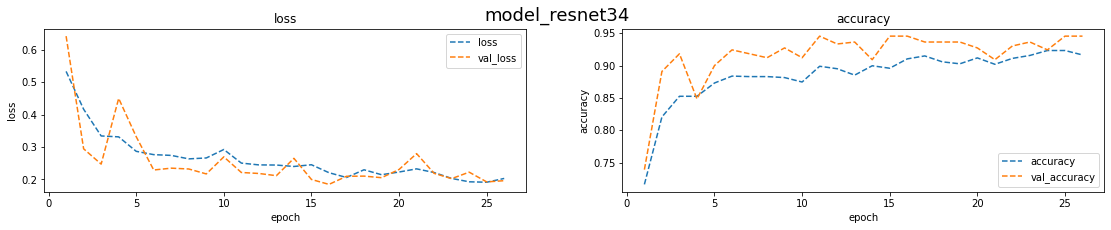

In [70]:
# plot model ouputs
plot_model_output(history, 'model_resnet34')

In [71]:
# post-trained
valid_model2(model_resnet34)

correct: 312  total: 330
accuracy = 0.945455


tensor([[6.9581e-01, 3.0419e-01],
        [9.9958e-01, 4.1551e-04],
        [9.9980e-01, 2.0008e-04],
        [4.2984e-03, 9.9570e-01],
        [6.1884e-04, 9.9938e-01],
        [9.9464e-01, 5.3643e-03],
        [5.4293e-04, 9.9946e-01],
        [9.1548e-01, 8.4524e-02],
        [5.1015e-05, 9.9995e-01],
        [5.2770e-02, 9.4723e-01]])

In [72]:
# Load saved model
model_resnet34 = torch.load('../Models/modelo_resnet34.pth')
model_resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### > make predictions

In [94]:
# -------> make predictions
test_transform = transforms.Compose([
    transforms.Resize(int(target_size*1.1)),
    transforms.CenterCrop(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224, 0.225])
    ])

In [99]:
# make prdictions
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def make_prediction(model, filename):
    #labels, _ = find_classes(path)
    img = Image.open(filename)
    img = test_transform(img)
    img = img.unsqueeze(0)
    prediction = model(img.to(device))
    prediction = prediction.argmax()
    print('class predicted: ',prediction.item())
    
make_prediction(model_resnet34, '../test_image.jpg')

class predicted:  0


### Custon Model

In [21]:
# Custon Model
model = NeuralNet(num_class=2)
model

NeuralNet(
  (cnn_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=4, threshold=0.000001, threshold_mode='abs', verbose=True)
model_save='../Models/custom_model.pth'
# RunModel
history = RunModel(model, train_loader, valid_loader, criterion, optimizer,
                   scheduler, model_save, n_epochs=30).train_model()

cpu


Epoch: 1, Training_Loss: 0.8044, Validation_Loss: 0.5798, Training_accuracy = 0.6459, Validation_accuracy = 0.6727, lr = 0.001
Validation loss decreased (inf --> 0.579825).  Saving model ...


Epoch: 2, Training_Loss: 0.5693, Validation_Loss: 0.5286, Training_accuracy = 0.7029, Validation_accuracy = 0.7485, lr = 0.001
Validation loss decreased (0.579825 --> 0.528586).  Saving model ...


Epoch: 3, Training_Loss: 0.5420, Validation_Loss: 0.4656, Training_accuracy = 0.7226, Validation_accuracy = 0.7788, lr = 0.001
Validation loss decreased (0.528586 --> 0.465619).  Saving model ...


Epoch: 4, Training_Loss: 0.4942, Validation_Loss: 0.5649, Training_accuracy = 0.7622, Validation_accuracy = 0.6636, lr = 0.001


Epoch: 5, Training_Loss: 0.4789, Validation_Loss: 0.4004, Training_accuracy = 0.7682, Validation_accuracy = 0.8030, lr = 0.001
Validation loss decreased (0.465619 --> 0.400433).  Saving model ...


Epoch: 6, Training_Loss: 0.4561, Validation_Loss: 0.3574, Training_accuracy = 0.7888, Validation_accuracy = 0.8485, lr = 0.001
Validation loss decreased (0.400433 --> 0.357414).  Saving model ...


Epoch: 7, Training_Loss: 0.4399, Validation_Loss: 0.3791, Training_accuracy = 0.7827, Validation_accuracy = 0.8364, lr = 0.001


Epoch: 8, Training_Loss: 0.4619, Validation_Loss: 0.3573, Training_accuracy = 0.7781, Validation_accuracy = 0.8576, lr = 0.001
Validation loss decreased (0.357414 --> 0.357336).  Saving model ...


Epoch: 9, Training_Loss: 0.4411, Validation_Loss: 0.3475, Training_accuracy = 0.7903, Validation_accuracy = 0.8424, lr = 0.001
Validation loss decreased (0.357336 --> 0.347465).  Saving model ...


Epoch: 10, Training_Loss: 0.4296, Validation_Loss: 0.3070, Training_accuracy = 0.7979, Validation_accuracy = 0.8909, lr = 0.001
Validation loss decreased (0.347465 --> 0.306973).  Saving model ...


Epoch: 11, Training_Loss: 0.4080, Validation_Loss: 0.4395, Training_accuracy = 0.8237, Validation_accuracy = 0.8000, lr = 0.001


Epoch: 12, Training_Loss: 0.4126, Validation_Loss: 0.3177, Training_accuracy = 0.8138, Validation_accuracy = 0.8606, lr = 0.001


Epoch: 13, Training_Loss: 0.4205, Validation_Loss: 0.3264, Training_accuracy = 0.8047, Validation_accuracy = 0.8576, lr = 0.001


Epoch: 14, Training_Loss: 0.3978, Validation_Loss: 0.3890, Training_accuracy = 0.8138, Validation_accuracy = 0.8424, lr = 0.001


Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 15, Training_Loss: 0.4176, Validation_Loss: 0.3825, Training_accuracy = 0.7986, Validation_accuracy = 0.8152, lr = 0.0001


Epoch: 16, Training_Loss: 0.3853, Validation_Loss: 0.2993, Training_accuracy = 0.8336, Validation_accuracy = 0.8879, lr = 0.0001
Validation loss decreased (0.306973 --> 0.299252).  Saving model ...


Epoch: 17, Training_Loss: 0.3790, Validation_Loss: 0.3007, Training_accuracy = 0.8321, Validation_accuracy = 0.8758, lr = 0.0001


Epoch: 18, Training_Loss: 0.3613, Validation_Loss: 0.2959, Training_accuracy = 0.8435, Validation_accuracy = 0.8848, lr = 0.0001
Validation loss decreased (0.299252 --> 0.295893).  Saving model ...


Epoch: 19, Training_Loss: 0.3681, Validation_Loss: 0.2979, Training_accuracy = 0.8351, Validation_accuracy = 0.8697, lr = 0.0001


Epoch: 20, Training_Loss: 0.3500, Validation_Loss: 0.3045, Training_accuracy = 0.8427, Validation_accuracy = 0.8758, lr = 0.0001


Epoch: 21, Training_Loss: 0.3495, Validation_Loss: 0.2977, Training_accuracy = 0.8359, Validation_accuracy = 0.8818, lr = 0.0001


Epoch: 22, Training_Loss: 0.3418, Validation_Loss: 0.3159, Training_accuracy = 0.8526, Validation_accuracy = 0.8758, lr = 0.0001


Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 23, Training_Loss: 0.3432, Validation_Loss: 0.3277, Training_accuracy = 0.8511, Validation_accuracy = 0.8697, lr = 1e-05


Epoch: 24, Training_Loss: 0.3505, Validation_Loss: 0.2992, Training_accuracy = 0.8412, Validation_accuracy = 0.8758, lr = 1e-05


Epoch: 25, Training_Loss: 0.3693, Validation_Loss: 0.3166, Training_accuracy = 0.8374, Validation_accuracy = 0.8727, lr = 1e-05


Epoch: 26, Training_Loss: 0.3183, Validation_Loss: 0.2988, Training_accuracy = 0.8609, Validation_accuracy = 0.8727, lr = 1e-05


Epoch: 27, Training_Loss: 0.3432, Validation_Loss: 0.3003, Training_accuracy = 0.8488, Validation_accuracy = 0.8727, lr = 1e-05


Epoch: 28, Training_Loss: 0.3414, Validation_Loss: 0.2945, Training_accuracy = 0.8465, Validation_accuracy = 0.8788, lr = 1e-05
Validation loss decreased (0.295893 --> 0.294451).  Saving model ...


Epoch: 29, Training_Loss: 0.3421, Validation_Loss: 0.3031, Training_accuracy = 0.8457, Validation_accuracy = 0.8727, lr = 1e-05


Epoch: 30, Training_Loss: 0.3472, Validation_Loss: 0.3051, Training_accuracy = 0.8518, Validation_accuracy = 0.8758, lr = 1e-05


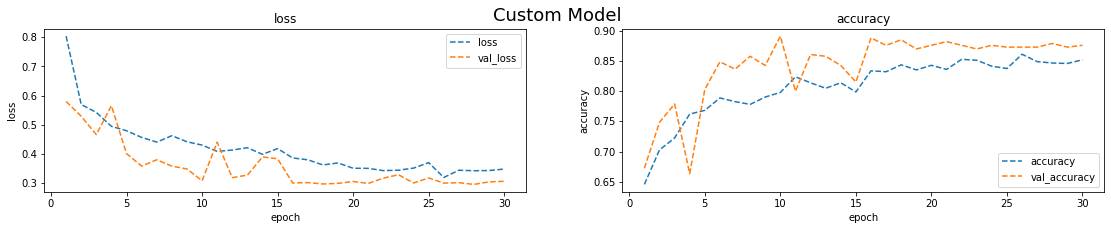

In [23]:
# plot model ouputs
plot_model_output(history, 'Custom Model')

In [26]:
valid_model2(model)

correct: 289  total: 330
accuracy = 0.875758


tensor([[9.4301e-01, 5.6991e-02],
        [3.0152e-05, 9.9997e-01],
        [9.9498e-01, 5.0211e-03],
        [9.9880e-01, 1.2033e-03],
        [2.8349e-01, 7.1651e-01],
        [9.9729e-01, 2.7083e-03],
        [9.6876e-01, 3.1239e-02],
        [9.9526e-01, 4.7366e-03],
        [9.9621e-01, 3.7927e-03],
        [9.8029e-01, 1.9706e-02]])

In [24]:
# test without "bn" in named parameters (requires_grad)
model_resnet34 = models.resnet34(pretrained=True)
for param in model_resnet34.parameters():
    param.requires_grad = False
model_resnet34.fc = nn.Sequential(nn.Linear(model_resnet34.fc.in_features,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, 2))

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet34.parameters(), lr=0.001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=4, threshold=0.000001, threshold_mode='abs', verbose=True)
model_save='../Models/modelo_resnet34.pth'
# RunModel
history = RunModel(model_resnet34, train_loader, valid_loader, criterion, optimizer,
                   scheduler, model_save, n_epochs=30).train_model()

cpu


Epoch: 1, Training_Loss: 0.5559, Validation_Loss: 0.3610, Training_accuracy = 0.7363, Validation_accuracy = 0.8364, lr = 0.001
Validation loss decreased (inf --> 0.360981).  Saving model ...


Epoch: 2, Training_Loss: 0.4646, Validation_Loss: 0.4820, Training_accuracy = 0.7751, Validation_accuracy = 0.7909, lr = 0.001


Epoch: 3, Training_Loss: 0.4406, Validation_Loss: 0.4340, Training_accuracy = 0.8017, Validation_accuracy = 0.8212, lr = 0.001


Epoch: 4, Training_Loss: 0.4403, Validation_Loss: 0.3489, Training_accuracy = 0.7743, Validation_accuracy = 0.8424, lr = 0.001
Validation loss decreased (0.360981 --> 0.348857).  Saving model ...


Epoch: 5, Training_Loss: 0.4454, Validation_Loss: 0.3374, Training_accuracy = 0.7948, Validation_accuracy = 0.8364, lr = 0.001
Validation loss decreased (0.348857 --> 0.337396).  Saving model ...


Epoch: 6, Training_Loss: 0.4236, Validation_Loss: 0.3918, Training_accuracy = 0.8055, Validation_accuracy = 0.8333, lr = 0.001


Epoch: 7, Training_Loss: 0.4708, Validation_Loss: 0.3308, Training_accuracy = 0.7842, Validation_accuracy = 0.8394, lr = 0.001
Validation loss decreased (0.337396 --> 0.330761).  Saving model ...


Epoch: 8, Training_Loss: 0.4213, Validation_Loss: 0.3491, Training_accuracy = 0.8070, Validation_accuracy = 0.8515, lr = 0.001


Epoch: 9, Training_Loss: 0.4026, Validation_Loss: 0.3445, Training_accuracy = 0.8138, Validation_accuracy = 0.8424, lr = 0.001


Epoch: 10, Training_Loss: 0.4237, Validation_Loss: 0.3223, Training_accuracy = 0.8055, Validation_accuracy = 0.8515, lr = 0.001
Validation loss decreased (0.330761 --> 0.322259).  Saving model ...


Epoch: 11, Training_Loss: 0.4290, Validation_Loss: 0.3306, Training_accuracy = 0.8055, Validation_accuracy = 0.8545, lr = 0.001


Epoch: 12, Training_Loss: 0.4041, Validation_Loss: 0.3297, Training_accuracy = 0.8176, Validation_accuracy = 0.8545, lr = 0.001


Epoch: 13, Training_Loss: 0.4104, Validation_Loss: 0.4594, Training_accuracy = 0.8078, Validation_accuracy = 0.8061, lr = 0.001


Epoch: 14, Training_Loss: 0.3933, Validation_Loss: 0.3549, Training_accuracy = 0.8229, Validation_accuracy = 0.8333, lr = 0.001


Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 15, Training_Loss: 0.3978, Validation_Loss: 0.3352, Training_accuracy = 0.8290, Validation_accuracy = 0.8576, lr = 0.0001


Epoch: 16, Training_Loss: 0.3807, Validation_Loss: 0.3876, Training_accuracy = 0.8283, Validation_accuracy = 0.8212, lr = 0.0001


Epoch: 17, Training_Loss: 0.3712, Validation_Loss: 0.3503, Training_accuracy = 0.8313, Validation_accuracy = 0.8364, lr = 0.0001


Epoch: 18, Training_Loss: 0.3738, Validation_Loss: 0.3684, Training_accuracy = 0.8374, Validation_accuracy = 0.8273, lr = 0.0001


Epoch: 19, Training_Loss: 0.3837, Validation_Loss: 0.4029, Training_accuracy = 0.8229, Validation_accuracy = 0.8091, lr = 0.0001


Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 20, Training_Loss: 0.3659, Validation_Loss: 0.3355, Training_accuracy = 0.8321, Validation_accuracy = 0.8576, lr = 1e-05
Early stopping!
patience times:  10


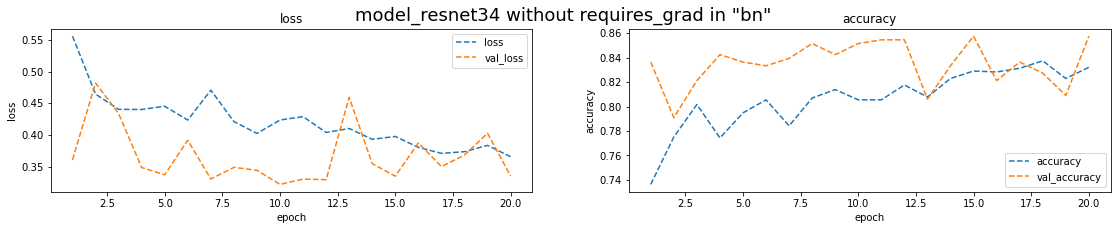

In [27]:
# plot model ouputs
plot_model_output(history, 'model_resnet34 without requires_grad in "bn"')